Osnabrück University - Computer Vision (Winter Term 2021/22) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 09: Local Features

## Introduction

This week's sheet should be solved and handed in before the end of **Tuesday, January 25, 2022**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Exercise 1: Local features and interest points [2 points]

**a)** Explain in your own words: What are *local features*? How are they used?

Basically there are two types of features being extracted from the images based on the application, local and global features. Features are sometimes referred to as descriptors. Global descriptors are generally used in image retrieval, object detection and classification, while the local descriptors are used for object recognition or identification.
There is a large difference between detection and identification. Detection is finding the existence of something/object (Finding whether an object is exist in image/video) where as Recognition is finding the identity (Recognizing a person/object) of an object.
Local features can be considered as certain patterns, or specific structures in images. Those local features are meant to be different from its surroundings with respect to texture, color and intensity. To name a few examples,Blobs and edge pixels are local features.

They are used as descriptors concerning object recognition. Ips have to me matched to a certain region whereas these regions can be described by local features and therefore form the basis for object recognition.


**b)** What are *interest points* and what are they used for? What properties are desirable?

Interest points, short IPs, are points in an image and in general not striking. However, when it comes to image processing, Ips have to be matched to a certain region. In the context of recognition, those regions even have to be described by a set of certain features, whereas those features again form the basis for object recognition.

We want an interesting point to be rich concerning image content withing the local window which is referring to brightness variation, color variation and so on. In other words, it should be "interesting", or "special" enough so that we would consider to match such a point. Some kind of robustness might be useful too, like being invariance to image rotation, scaling and lightning. This makes it possible to find a certain point under arbitrary conditions. Moreover, it is advantageous to choose an interest point with a well defined position, because if you want to recognize a certain point in an image it is useful to have appropriate information about where this point is. In a nutshell, you may summarize the most important properties as Saliency and Stability.

## Exercise 2: Computing interest points [6 points]


**a)** Explain in your own words the idea of the Moravec IP operator. What are its properties? Implement this IP operator and apply it to the image `lighthouse.png`. Try different window sizes and threshold values.

The Moravec IP operator is a basic IP detector which is searching for edges between regions. It is not currently used anymore, since it is not working out properly, however advanced operator are built upon this basic idea. First of all, the operator is based on one claim, namely that one window is salient if it is "unique" concerning its surroundings. Unique in a way, that it differs from its surroundings. Further, one simple idea is to shift a certain window by one pixel and compare it to itself. The operator is now comparing the shifted window in 4 directions, namely horizontal, vertical, and both diagonals. The minimum of these 4 values is taken. Finally, it evaluates all pixels within the search window.

Certain Properties are that the operator is relative easy to implement in comparison to other operators. On the other hand, the operator is anisotropic, which means it is not robust against rotation, and defined with hard terms, meaning that the defined window goes with a window like box filter.

In [60]:
%matplotlib inline
import imageio
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from PIL import Image


img = Image.open('images/images/lighthouse.png').convert("L")

window_size = 3
threshold = .2

def moravec(img, window_size):
    """Moravec corner detector.
    
    Arguments
    ---------
    img: np.ndarray
        The input image
    window_size: int
        The size of the window to consider

    Results
    -------
    response: np.ndarray
        Response (of the same size as img), indicating interest points.
    """
    response = np.zeros_like(img)
    # YOUR CODE HERE
    
    print(img.size)
    
    # squared window_size
    l = window_size 
    k = window_size
     
    corners = []
    xy_shifts = [(1, 0), (1, 1), (0, 1), (-1, 1)]

    
    # loop through every pixel 
    for y in range(1, img.size[1]-1):
        for x in range(1, img.size[0]-1):
            
            min_v = []
            # loop through 4 shifts 
            for shift in xy_shifts:
                diff = img.getpixel((x + shift[0], y + shift[1]))
                diff = diff - img.getpixel((x, y))
                diff = np.power(diff, 2)
                min_v.append(diff)
            
            
            min_v = min(min_v)
            # corner if diff exceeds threshold
            if min_v > threshold:
                #corners.append((x, y))
                response[x,y] = (x, y)
            # wo der min diff ist die coordinates nehmen 
           # corners.append((x, y))
    
    print(response.shape)
    #return corners

    return response

response = moravec(img, window_size)

thresholded = np.zeros_like(response)
thresholded[response > threshold] = 1

plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.imshow(img, cmap='gray'); plt.title('Original')
plt.subplot(2,2,2); plt.imshow(response, cmap='viridis'); plt.title('Moravec "heatmap"')
plt.colorbar()
plt.subplot(2,2,3); plt.imshow(thresholded, cmap='gray'); plt.title(f'Thresholded (>{threshold})')
plt.subplot(2,2,4); plt.imshow(img[1:-1,:-1], cmap='gray'); plt.title('Corners')
mask = np.zeros(thresholded.shape + (4,), dtype=int)
mask[:,:,0] = 255
mask[:,:,3] = thresholded*255
plt.imshow(mask, interpolation='none')
plt.tight_layout()
plt.show()

(472, 307)


ValueError: setting an array element with a sequence.

**b)** How does the Harris corner detector work and in what sense does it improve the Moravec IP operator. Implement the Harris corner detector and apply it to `lighthouse.png`. Again, try different "window sizes" (values for $\sigma$).

The detector works like the following: First of all a sobel filter is applied in order to get g_x and g_y.  After that a structure tensor is used as an analytical solution to compute the differences, wheras the idea of a structure tensor is to combines the gradients in the neighborhood of a point. Eventually, the edge / corner strenght is calculated. For now the local maximum in the 8-neighbourhood correlates to corners. 

The Harris corner detector improves the Moravec IP operator in a way that it is not using an anisotropic function, rather it uses the Gaussian as an isotropic, meaning a function which is independent on directions, windowing function.

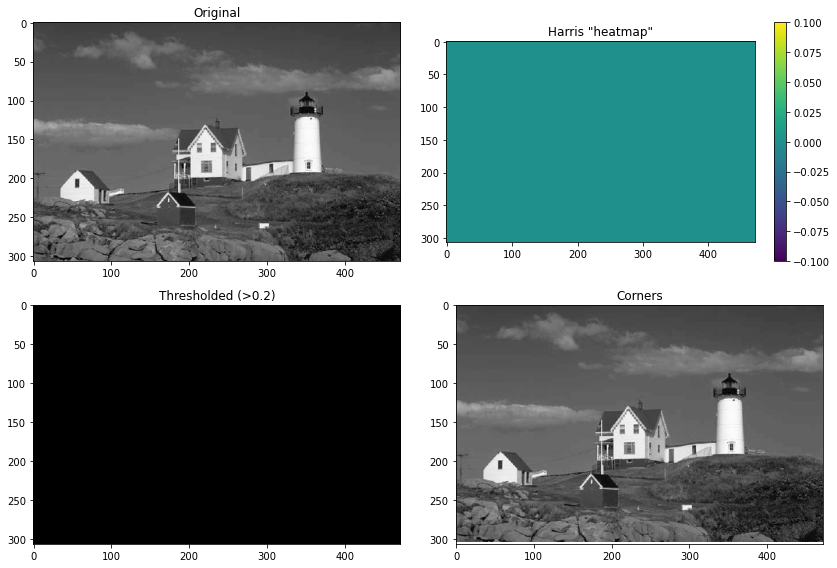

In [62]:
%matplotlib inline
import imageio
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

k = .04
window_size = 3

img = imageio.imread('images/images/lighthouse.png', pilmode='F')/255.

def harris(img, window_size=3, k=0.04):
    """Harris corner detector.
    
    Arguments
    ---------
    img: np.ndarray
        The input image
    window_size: int
        The size of the window to consider
    k: float
        The parameter k
        
    Results
    -------
    response: np.ndarray
        Response (of the same size as img), indicating interest points.
    """
    response = np.zeros_like(img)
    # YOUR CODE HERE
    return response

response = harris(img, window_size, k)

thresholded = np.zeros_like(response)
thresholded[response > threshold] = 1

plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.imshow(img, cmap='gray'); plt.title('Original')
plt.subplot(2,2,2); plt.imshow(response, cmap='viridis'); plt.title('Harris "heatmap"')
plt.colorbar()
plt.subplot(2,2,3); plt.imshow(thresholded, cmap='gray'); plt.title(f'Thresholded (>{threshold})')
plt.subplot(2,2,4); plt.imshow(img[1:-1,:-1], cmap='gray'); plt.title('Corners')
mask = np.zeros(thresholded.shape + (4,), dtype=int)
mask[:,:,0] = 255
mask[:,:,3] = thresholded*255
plt.imshow(mask, interpolation='none')
plt.tight_layout()
plt.show()

## Exercise 3: Understanding SIFT [4 Points]

*Hint:* For this and the next exercise it is really helpful to take a look at:
* [[Lowe04]](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) David G. Lowe: Distinctive Image Features from 
Scale-Invariant Keypoints. IJCV, 2004.

**a)** Explain the two main steps that are typically performed to construct local features. How are these steps realized in SIFT?

Scale invariant Feature Transform

1. Scale-space extrema detection: The first stage of computation searches over all scales
and image locations. It is implemented efficiently by using a difference-of-Gaussian
function to identify potential interest points that are invariant to scale and orientation.
2. Keypoint localization: At each candidate location, a detailed model is fit to determine
location and scale. Keypoints are selected based on measures of their stability.
3. Orientation assignment: One or more orientations are assigned to each keypoint lo-
cation based on local image gradient directions. All future operations are performed
on image data that has been transformed relative to the assigned orientation, scale, and
location for each feature, thereby providing invariance to these transformations.
4. Keypoint descriptor: The local image gradients are measured at the selected scale
in the region around each keypoint. These are transformed into a representation that
allows for significant levels of local shape distortion and change in illuminatio



1. Detect extrema in scale space:
Search over all pixels an on all scales
2. Keypoint (IP) detection:
 Select stable keypoints
 Find position with subpixel precision
3. Direction detection
Extraction of one or more directions based on gradients
4. Keypoint descriptor:
Transform to a standardized description

**b)** SIFT key points (interest points) are claimed to invariant to changes in (a) scale, (b) orientation, (c) illumination, and (d) affine transformations. Describe how SIFT key points are computed and explain how this construction contributes to each of these individual goals.

b + c : 

**c)** Explain how SIFT descriptors are constructed and motivate this construction.

YOUR ANSWER HERE

**d)** *Object recognition:* Design an object recognition system based on local features (like SIFT)? Describe how to train such a system and how to perform the recognition task.

YOUR ANSWER HERE

## Exercise 4: Applying SIFT [5 Points]

In this exercise we invite you to explore the SIFT implementation provided by OpenCV. You may use whatever functions you find in that library.

**a)** *Keypoint detection*: look up how to detect SIFT keypoints with OpenCV and find keypoints in the image `lighthouse.png`. Show the keypoints in the image. Find ways to indicate scale and direction of the keypoints.

In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('images/lighthouse.png')
assert img is not None, "Error loading image"

img_keypoints = np.zeros_like(img)
img_keypoints2 = np.zeros_like(img)

# YOUR CODE HERE

plt.figure(figsize=(20, 30))
plt.subplot(3, 1, 1)
plt.imshow(img)
plt.title('The original image')
plt.subplot(3, 1, 2)
plt.imshow(img_keypoints)
plt.title('Keypoints detected by sift')
plt.subplot(3, 1, 3)
plt.imshow(img_keypoints2)
plt.title('Keypoints detected by sift')
plt.show()


**b)** *Feature matching*: Take two images of the same object (using your webcam, or if this does not work by some other technique), compute their SIFT features and match them. Show which keypoints are matched. Try how different position, scale, and orientation influence the matching.

In [ ]:
# Part 1: capture two images with the webcam (and store them on disk)

%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import time

name1 = input("Enter name for the first image ...") or "image1"
camera = cv2.VideoCapture(0)
time.sleep(.5)
ok, frame1 = camera.read()
camera.release()
assert frame1 is not None, "Camera did not work!"
cv2.imwrite(name1 + '.png', frame1)

name2 = input("Enter name for the second image ...") or "image2"
time.sleep(.5)
camera = cv2.VideoCapture(0)
time.sleep(.5)
ok, frame2 = camera.read()
camera.release()
assert frame2 is not None, "Camera did not work!"
cv2.imwrite(name2 + '.png', frame2)

plt.figure(figsize=(12, 6))
plt.suptitle("Frame: {}, type={}".format(frame1.shape, frame1.dtype))
plt.subplot(1, 2, 1)
plt.imshow(frame1)
plt.title(name1)
plt.subplot(1, 2, 2)
plt.imshow(frame2)
plt.title(name2)

plt.show()

In [ ]:
# Part 2: load a pair of images, compute their SIFT features and match them. 

img1 = cv2.imread('image1.png')
img2 = cv2.imread('image2.png')

assert img1 is not None, "Error loading image 1"
assert img2 is not None, "Error loading image 2"

# YOUR CODE HERE

**c)** *Object recognition*: build a small database of objects by taking snapshots and storing them along with their SIFT descriptors. Then try to query your database by taking new images and retrieving the best match.

In [ ]:
# Part 1: store objects in the database

%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import time

name = input("Enter name for new object ...") or "new object"
camera = cv2.VideoCapture(0)
time.sleep(0.5)
ok, frame = camera.read()
camera.release()
assert frame is not None, "Camera does not work!"

# Compute features and store them in your database


if not 'sift' in globals():
    sift = cv2.xfeatures2d.SIFT_create()
keypoints, descriptor = sift.detectAndCompute(frame, None)

if not 'database' in globals() or not isinstance(database, dict):
    database = {name: descriptor}
else:
    database[name] = descriptor

print(database.keys())
import imageio
imageio.imwrite(name + '.png', frame[:,:,::-1])


In [ ]:
print(len(database['r2d2']))
print(len(database['abc']))

In [ ]:
# Part 2: retrieve objects from the database

#input("Press enter to capture an image ...")
camera = cv2.VideoCapture(0)
time.sleep(0.5)
ok, frame = camera.read()
camera.release()
assert frame is not None, "Camera did not work!"

# Now look up the best matching object from your database


assert 'database' in globals() or not isinstance(database, dict), "No database available"

# get the keypoints
if not 'sift' in globals():
    sift = cv2.xfeatures2d.SIFT_create()
keypoints, descriptor = sift.detectAndCompute(frame, None)

# prepare the matcher
FLANN_INDEX_KDITREE=0
flannParam = dict(algorithm=FLANN_INDEX_KDITREE, tree=5)
flann = cv2.FlannBasedMatcher(flannParam, {})
# store images from our database
flann.add(list(database.values()))
for d in database.values():
    flann.add(d)

# count matches
counter = np.zeros(len(database), dtype=np.int)
matches = flann.knnMatch(descriptor, k=2)
for m,n in matches:
    if (m.imgIdx == n.imgIdx) or (m.distance < 0.75 *n.distance):
        counter[m.imgIdx] += 1

# output the results
print("Matches:")
for n, c in zip(database, counter):
    print(f"  image '{n}': {c}")

print(f"Best match: '{list(database)[counter.argmax()]}'")


## Exercise 5: Rectangle features [3 Points]

**a)** Explain the idea of rectangle features.

Compared to SIFT, rectangle feature are not related to interesting points. Rather, so called sliding windows are used. They are moved along an image and perform detection via recognition which means nothing other than sliding windows being classified. Therefore, both steps are done at the same time. In Using so called integral images, this procedure can be speeded up, this is necessary due to the amount of required sliding windows. Simple rectangle features are built of a black and a white rectangular part. The feature value of the rectangle features are defined by the difference of the integral over the white and the black area. Eventually, the object recognition is done by a trained cascade of classifier which are evaluating simple rectangle features in the search windows.

**b)** What is an integral image and how does it help to compute rectangle features?

An integral image is simply the sum of each pixel concerning the original image that is above or to the left. Generally, these images are used in order to make the computation of the rectangle features easier. The computation gets easier because the integral image already gives information about the rectangle feature in a way that only 3 additions are neccessary when it comes to the computational cost. What makes the integral image interesting is also the feature of being independent of the rectangle's size.

**c)** What is a classifier cascade and how is it used in the context of rectangle features?

In order to detect a certain object in an image, it is necessary that a few hypotheses are classified. However, in terms of computationally effort not every hypothesis is useful to classify since usually most hypotheses correspond to the background of the image. This is where the classifier cascade comes in. The cascade is evaluating features sequentially which enables to sort out certain candidate locations quite early and therefore advances the computational effort.

Object detection, requires combinations of rectangle features. A threshold is choses in order to separate positive
samples, realting to objects, from negative samples, corresponding to the background. The cascade is now computing in each step all features on all locations and all scales. Eventually, the feature with the most appropriate separation is chosen and a threshold is assigned. One advantage of this approach concerns the samples which are already rejected by earlier weak classifiers, because they are not used for training further classifiers.

**d)** Compare SIFT and rectangle features. Name pros and cons.

SIFT:
Detection of IPs in scale space
Descriptors for regions around IPs
Similarity measure for images based on local features
    Locality: features are local, so robust to occlusion and clutter (no prior segmentation)
    Distinctiveness: individual features can be matched to a large database of objects
    Quantity: many features can be generated for even small objects
    Efficiency: close to real-time performance
    Extensibility: can easily be extended to a wide range of different feature types, with each adding robustness




Viola-Jones approach:
Rectangle features, efficient computation using integral image
Cascade classifier
Boosting to combine weak classifiers to a strong classifier